# Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# display settings
pd.set_option('display.max_columns', None)

# load dataset
df = pd.read_csv("//clean_1mg_dataset.csv")

df.head()

,Generic_Name,Strength,Brand_Name,Molecule,Manufacturer,Price_INR,Availability,Therapeutic_Class,Is_Available
0,Metformin,500.0,Glycomet 500 SR Tablet,Metformin (500mg),USV Private Limited,41.20,In Stock,Diabetes,1
1,Metformin,500.0,Glyciphage SR 500mg Tablet,Metformin (500mg),Franco-Indian Pharmaceuticals Pvt Ltd,26.62,In Stock,Diabetes,1
2,Metformin,500.0,GlUCOnorm SR 500mg Tablet,Metformin (500mg),Lupin Ltd,31.70,In Stock,Diabetes,1
3,Metformin,500.0,Cetapin XR 500mg Tablet,Metformin (500mg),Sanofi India Ltd,47.70,In Stock,Diabetes,1
4,Metformin,500.0,Okamet 500 Tablet,Metformin (500mg),Cipla Ltd,20.60,In Stock,Diabetes,1


In [ ]:
from sqlalchemy import create_engine
from urllib.parse import quote_plus

DB_USER = "postgres"
DB_PASS = "******"
DB_HOST = "*******"
DB_PORT = "5432"
DB_NAME = "medicine_availability"

DB_PASS_ENC = quote_plus(DB_PASS)

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASS_ENC}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)


## Price Dispersion/Variation


### How significant is the price variation between brands selling the same molecule and strength?
For each molecule (Generic_Name + Strength): number of brands, cheapest price, most expensive price, and premium %.


### Brand Name Normalization (before brand counts)
To avoid counting the same brand multiple times due to dosage form or strength in the name, we normalize `Brand_Name` to a `Brand_Core` field.


In [2]:
import re

def normalize_brand(name: str):
    if not isinstance(name, str):
        return 'unknown'
    text = name.lower()
    # remove any numbers (e.g., 500, 650, 0.5) whether standalone or attached
    text = re.sub(r'\d+(?:\.\d+)?', '', text)
    # remove strength units like mg/ml/etc (if any leftover text patterns)
    text = re.sub(r'\b(mg|mcg|g|ml|iu|%)\b', '', text)
    # remove dosage form keywords
    text = re.sub(r'\b(tab|tablet|tabs|cap|capsule|caps|syrup|susp|suspension|inj|injection|iv|infusion|drops?|ointment|cream|gel|lotion|spray|inhaler|solution|powder|granules|suppository)\b', '', text)
    # remove release/variant tags
    text = re.sub(r'\b(sr|xr|er|cr|pr|dr|mr|xl|od|dt)\b', '', text)
    # cleanup extra spaces and punctuation
    text = re.sub(r'[^a-z0-9 ]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text if text else 'unknown'

# Rebuild Brand_Core with the updated normalization
df['Brand_Core'] = df['Brand_Name'].apply(normalize_brand)
df[['Brand_Name','Brand_Core']].head()


,Brand_Name,Brand_Core
0,Glycomet 500 SR Tablet,glycomet
1,Glyciphage SR 500mg Tablet,glyciphage
2,GlUCOnorm SR 500mg Tablet,gluconorm
3,Cetapin XR 500mg Tablet,cetapin
4,Okamet 500 Tablet,okamet


In [3]:
df["Brand_Name"].nunique()

1861

In [4]:
df["Brand_Core"].nunique()

1741

In [5]:
# Counting brands per molecule
brand_counts = df.groupby('Molecule')["Brand_Core"].nunique().reset_index()
brand_counts.columns = ['Molecule','Brand_Core']

# Calculating price statistics per molecule
price_stats = (df.groupby('Molecule')["Price_INR"].agg(Cheapest_Price='min', Premium_Price='max').reset_index())

# Calculating % premium
price_stats['Price_Variation_Pct'] = ((price_stats['Premium_Price'] - price_stats['Cheapest_Price']) / price_stats['Cheapest_Price']) * 100

# Merge for market structure view
molecule_price_dispersion = price_stats.merge(brand_counts, on='Molecule', how='left')
molecule_price_dispersion.head()


,Molecule,Cheapest_Price,Premium_Price,Price_Variation_Pct,Brand_Core
0,Acarbose (50mg),29.3,188.00,541.638225,62
1,Aceclofenac (100mg),22.3,76.50,243.049327,7
2,Amlodipine (5mg),13.8,80.00,479.710145,20
3,Aspirin (75mg),5.0,5.29,5.800000,2
4,Atenolol (50mg),9.6,104.00,983.333333,57


In [6]:
# Basic summary statistics
molecule_price_dispersion['Price_Variation_Pct'].describe()

count      34.000000
mean     1859.415016
std      2339.964028
min         0.000000
25%       530.127382
50%       935.416667
75%      2431.250000
max      9483.333333
Name: Price_Variation_Pct, dtype: float64

In [7]:
# Top 10 most overpriced molecules (molecule-level)
molecule_price_dispersion.sort_values('Price_Variation_Pct', ascending=False).head(10)


,Molecule,Cheapest_Price,Premium_Price,Price_Variation_Pct,Brand_Core
20,Ibuprofen (400mg),4.8,460.0,9483.333333,24
14,Empagliflozin (10mg),36.8,3219.0,8647.282609,74
13,Doxycycline (100mg),7.4,518.0,6900.000000,82
21,Ketorolac (10mg),13.8,552.0,3900.000000,113
9,Cefuroxime (500mg),14.4,549.0,3712.500000,104
6,Atorvastatin (20mg),11.0,395.0,3490.909091,89
23,Losartan (50mg),4.6,159.0,3356.521739,80
5,Atorvastatin (10mg),6.0,159.0,2550.000000,43
32,Tramadol (50mg),4.0,103.0,2475.000000,129
26,Metronidazole (400mg),5.5,132.0,2300.000000,33


In [ ]:
# Visualize price dispersion
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(molecule_price_dispersion['Price_Variation_Pct'], bins=30)
plt.title('Price Premium Distribution by Molecule')
plt.xlabel('Price Variation %')
plt.ylabel('Count of Molecules')
plt.show()


In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(molecule_price_dispersion['Brand_Count'], molecule_price_dispersion['Price_Variation_Pct'])
plt.xlabel('Number of Brands')
plt.ylabel('Price Variation %')
plt.title('Brand Count vs Price Premium')
plt.show()


### Outlier Check: Ibuprofen 400 mg
This checks the extreme premium.


In [8]:
is_ibuprofen = df['Molecule'].str.contains('Ibuprofen', case=False, na=False) & df['Strength'].astype(str).str.contains('400', na=False)
df.loc[is_ibuprofen, ['Brand_Name','Price_INR','Manufacturer']].sort_values('Price_INR', ascending=False).head(10)


,Brand_Name,Price_INR,Manufacturer
1362,Inzan IV 400mg Infusion,460.00,Hetero Healthcare Limited
1367,Ibupal 400mg Tablet,35.40,Jagsonpal Pharmaceuticals Ltd
1353,Brufen 400 Tablet,25.10,Abbott
1363,Brufen 400 Tablet,18.20,Abbott
1354,Ibuprol 400 Tablet,12.19,Zeelab Pharmacy Pvt Ltd
1357,Intafen 400mg Tablet,12.00,Intas Pharmaceuticals Ltd
1378,Neurofen 400mg Tablet,11.60,Globela Pharma Pvt Ltd
1373,Emflam 400mg Tablet,11.00,Merck Ltd
1361,Ibugam 400 Tablet,10.80,Omega Pharmaceuticals Pvt Ltd
1359,Danaibu 400mg Tablet,10.60,Dana Pharmaceuticals Pvt Ltd


### Dosage Form Normalization (for fair price comparison)
Price dispersion can be inflated if we mix tablets with IV infusions. Extract dosage form from brand names to compare like‑for‑like.


In [9]:
import re

FORM_PATTERNS = {
    'tablet': r'\b(tab|tablet|tabs)\b',
    'capsule': r'\b(cap|capsule|caps)\b',
    'syrup': r'\b(syrup)\b',
    'suspension': r'\b(susp|suspension)\b',
    'injection': r'\b(inj|injection)\b',
    'infusion': r'\b(iv|infusion)\b',
    'drop': r'\b(drop|drops)\b',
    'ointment': r'\b(ointment|oint)\b',
    'cream': r'\b(cream)\b',
    'gel': r'\b(gel)\b',
    'lotion': r'\b(lotion)\b',
    'spray': r'\b(spray)\b',
    'inhaler': r'\b(inhaler)\b',
    'solution': r'\b(solution)\b',
    'powder': r'\b(powder)\b',
    'granules': r'\b(granules)\b',
    'suppository': r'\b(suppository)\b'
}

def extract_form(brand_name: str):
    if not isinstance(brand_name, str):
        return 'unknown'
    text = brand_name.lower()
    for form, pattern in FORM_PATTERNS.items():
        if re.search(pattern, text):
            return form
    return 'unknown'

df['Dosage_Form'] = df['Brand_Name'].apply(extract_form)
df['Dosage_Form'].value_counts().head(10)


Dosage_Form
tablet       1727
injection      85
capsule        71
infusion        8
drop            1
syrup           1
Name: count, dtype: int64

### Form‑Controlled Price Dispersion (Molecule + Form)
This shows the highest premiums within the same dosage form, so IV infusions do not distort tablet comparisons.


In [10]:
molecule_price_dispersion = (
    df.groupby(['Molecule','Dosage_Form'])['Price_INR']
      .agg(Cheapest_Price='min', Premium_Price='max', Listings='count')
      .reset_index()
)
molecule_price_dispersion['Price_Variation_Pct'] = ((molecule_price_dispersion['Premium_Price'] - molecule_price_dispersion['Cheapest_Price']) / molecule_price_dispersion['Cheapest_Price']) * 100
molecule_price_dispersion.sort_values('Price_Variation_Pct', ascending=False).head(10)


,Molecule,Dosage_Form,Cheapest_Price,Premium_Price,Listings,Price_Variation_Pct
22,Empagliflozin (10mg),tablet,36.8,3219.0,75,8647.282609
33,Ketorolac (10mg),tablet,13.8,552.0,119,3900.000000
12,Cefuroxime (500mg),tablet,14.4,549.0,107,3712.500000
6,Atorvastatin (20mg),tablet,11.0,395.0,89,3490.909091
36,Losartan (50mg),tablet,4.6,159.0,80,3356.521739
5,Atorvastatin (10mg),tablet,6.0,159.0,43,2550.000000
39,Metronidazole (400mg),tablet,5.5,132.0,36,2300.000000
20,Doxycycline (100mg),injection,31.7,518.0,34,1534.069401
44,Pioglitazone (15mg),tablet,5.0,80.0,13,1500.000000
7,Azithromycin (500mg),injection,14.4,218.6,3,1418.055556


### Form‑Controlled Dispersion Charts
These charts show dispersion after controlling for dosage form (like‑for‑like comparisons).


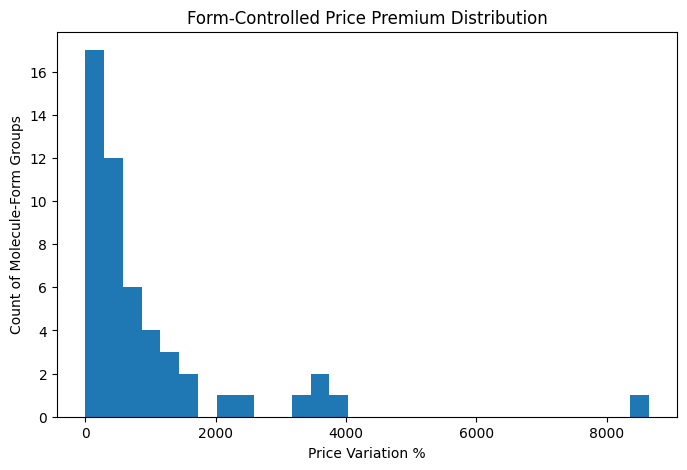

In [15]:
# Histogram of form-controlled premium %
plt.figure(figsize=(8,5))
plt.hist(molecule_price_dispersion['Price_Variation_Pct'], bins=30)
plt.title('Form-Controlled Price Premium Distribution')
plt.xlabel('Price Variation %')
plt.ylabel('Count of Molecule-Form Groups')
plt.show()


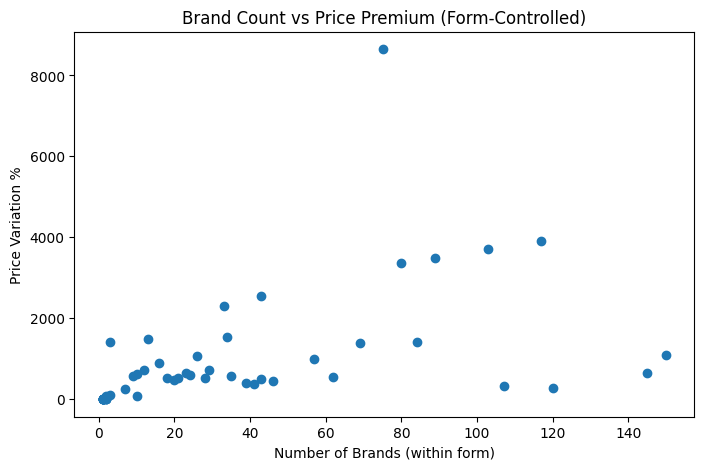

In [16]:
# Scatter: brand count vs premium % within form (optional market structure view)
form_brand_counts = df.groupby(['Molecule','Dosage_Form'])['Brand_Name'].nunique().reset_index()
form_brand_counts.columns = ['Molecule','Dosage_Form','Brand_Count']
form_market = molecule_price_dispersion.merge(form_brand_counts, on=['Molecule','Dosage_Form'], how='left')

plt.figure(figsize=(8,5))
plt.scatter(form_market['Brand_Count'], form_market['Price_Variation_Pct'])
plt.xlabel('Number of Brands (within form)')
plt.ylabel('Price Variation %')
plt.title('Brand Count vs Price Premium (Form-Controlled)')
plt.show()


### Oral Forms Only (Tablets/Capsules/Syrups)
This view focuses on the most common patient‑purchased forms.


In [11]:
oral_forms = ['tablet','capsule','syrup','suspension']
oral_dispersion = molecule_price_dispersion[molecule_price_dispersion['Dosage_Form'].isin(oral_forms)]
oral_dispersion.sort_values('Price_Variation_Pct', ascending=False).head(10)


,Molecule,Dosage_Form,Cheapest_Price,Premium_Price,Listings,Price_Variation_Pct
22,Empagliflozin (10mg),tablet,36.8,3219.0,75,8647.282609
33,Ketorolac (10mg),tablet,13.8,552.0,119,3900.000000
12,Cefuroxime (500mg),tablet,14.4,549.0,107,3712.500000
6,Atorvastatin (20mg),tablet,11.0,395.0,89,3490.909091
36,Losartan (50mg),tablet,4.6,159.0,80,3356.521739
5,Atorvastatin (10mg),tablet,6.0,159.0,43,2550.000000
39,Metronidazole (400mg),tablet,5.5,132.0,36,2300.000000
44,Pioglitazone (15mg),tablet,5.0,80.0,13,1500.000000
23,Enalapril (5mg),tablet,3.9,59.2,87,1417.948718
49,Tramadol (50mg),tablet,6.9,103.0,69,1392.753623


# Price vs Availability


In [12]:
# Remove molecules with too few brands

brand_counts = df.groupby("Molecule")["Brand_Core"].nunique()

valid_molecules = brand_counts[brand_counts >= 4].index

df = df[df["Molecule"].isin(valid_molecules)]

In [13]:
print("Remaining rows:", len(df))
print("Molecules analyzed:", df["Molecule"].nunique())

Remaining rows: 1890
Molecules analyzed: 32


In [14]:
# Create price percentile inside each molecule

df["Price_Percentile"] = df.groupby("Molecule")["Price_INR"]\
                           .rank(pct=True, method="average")

In [15]:
# Assign price tiers
# Bottom 25% → Budget
# Middle 50% → Mid
# Top 25% → Premium

def assign_tier(p):
    if p <= 0.25:
        return "Budget"
    elif p >= 0.75:
        return "Premium"
    else:
        return "Mid"

df["Price_Tier"] = df["Price_Percentile"].apply(assign_tier)

In [16]:
df["Price_Tier"].value_counts()

Price_Tier
Mid        948
Premium    481
Budget     461
Name: count, dtype: int64

In [17]:
availability_by_tier = df.groupby("Price_Tier")["Is_Available"].mean()

print(availability_by_tier)

Price_Tier
Budget     0.568330
Mid        0.656118
Premium    0.700624
Name: Is_Available, dtype: float64


We can see that budget drugs are 56% in stock, mid are 65% in stock and premium 70% in stock

In [18]:
tier_summary = df.groupby("Price_Tier").agg(
    Listings=("Brand_Name", "count"),
    Availability_Rate=("Is_Available", "mean"),
    Avg_Price=("Price_INR", "mean")
).reset_index()

tier_summary["Availability_Rate"] = tier_summary["Availability_Rate"] * 100

tier_summary

,Price_Tier,Listings,Availability_Rate,Avg_Price
0,Budget,461,56.832972,48.934620
1,Mid,948,65.611814,87.435011
2,Premium,481,70.062370,161.872162


## Market Competition vs Availability


In [19]:
brand_counts.head()

Molecule
Acarbose (50mg)        62
Aceclofenac (100mg)     7
Amlodipine (5mg)       20
Aspirin (75mg)          2
Atenolol (50mg)        57
Name: Brand_Core, dtype: int64

In [20]:
# Add availability rate per molecule

availability_per_molecule = (
    df.groupby("Molecule", as_index=False)["Is_Available"].mean()
    .rename(columns={"Is_Available": "Molecule_Availability_Rate"})
)


availability_per_molecule

,Molecule,Molecule_Availability_Rate
0,Acarbose (50mg),0.048387
1,Aceclofenac (100mg),0.428571
2,Amlodipine (5mg),0.571429
3,Atenolol (50mg),0.896552
4,Atorvastatin (10mg),0.906977
5,Atorvastatin (20mg),0.955056
6,Azithromycin (500mg),0.840764
7,Cefixime (200mg),0.904762
8,Cefuroxime (500mg),0.879630
9,Ciprofloxacin (500mg),0.972973


In [22]:
market_competition = pd.merge(
    brand_counts,
    availability_per_molecule,
    on=["Molecule"])
market_competition = market_competition.rename(columns={"Brand_Core":"Number_of_Brands"})

In [23]:
market_competition["Competition_Level"] = pd.qcut(
    market_competition["Number_of_Brands"],
    q=3,
    labels=["Low Competition","Moderate Competition","High Competition"]
)

In [24]:
market_competition.head()

,Molecule,Number_of_Brands,Molecule_Availability_Rate,Competition_Level
0,Acarbose (50mg),62,0.048387,Moderate Competition
1,Aceclofenac (100mg),7,0.428571,Low Competition
2,Amlodipine (5mg),20,0.571429,Low Competition
3,Atenolol (50mg),57,0.896552,Moderate Competition
4,Atorvastatin (10mg),43,0.906977,Moderate Competition


In [25]:
competition_summary = market_competition.groupby("Competition_Level").agg(
    Avg_Availability=("Molecule_Availability_Rate","mean"),
    Avg_Number_of_Brands=("Number_of_Brands","mean"),
    Molecules=("Number_of_Brands","count")
).reset_index()

competition_summary

/var/folders/d7/sls28l7j5cd0yz_6ktdxxq180000gn/T/ipykernel_48057/830596073.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  competition_summary = market_competition.groupby("Competition_Level").agg(


,Competition_Level,Avg_Availability,Avg_Number_of_Brands,Molecules
0,Low Competition,0.640914,15.818182,11
1,Moderate Competition,0.604594,44.500000,10
2,High Competition,0.662771,109.727273,11


## Therapeutic Class vs Availability


Availability rate per category:

In [26]:
category_availability = (df.groupby('Therapeutic_Class')['Is_Available'].mean().reset_index())

# convert to percentage
category_availability['Availability_%'] = category_availability['Is_Available'] * 100

category_availability.sort_values(by='Availability_%', ascending=False)

,Therapeutic_Class,Is_Available,Availability_%
1,Cardiac,0.786058,78.605769
0,Antibiotics,0.779221,77.922078
2,Diabetes,0.526971,52.697095
3,Pain relief,0.420370,42.037037


Price level per category:

In [27]:
category_price = (df.groupby('Therapeutic_Class')['Price_INR'].median().reset_index())

category_price.rename(columns={'Price_INR':'Median_Price'}, inplace=True)

category_price.sort_values(by='Median_Price', ascending=False)



,Therapeutic_Class,Median_Price
2,Diabetes,91.0
3,Pain relief,71.2
0,Antibiotics,66.5
1,Cardiac,44.2


In [28]:
# Combine both

category_analysis = pd.merge(category_availability, category_price, on='Therapeutic_Class')

category_analysis

,Therapeutic_Class,Is_Available,Availability_%,Median_Price
0,Antibiotics,0.779221,77.922078,66.5
1,Cardiac,0.786058,78.605769,44.2
2,Diabetes,0.526971,52.697095,91.0
3,Pain relief,0.420370,42.037037,71.2


Do higher priced therapeutic categories have more reliable availability?

Identifying the riskiest category

In [29]:
category_analysis.sort_values(by='Availability_%')

,Therapeutic_Class,Is_Available,Availability_%,Median_Price
3,Pain relief,0.420370,42.037037,71.2
2,Diabetes,0.526971,52.697095,91.0
0,Antibiotics,0.779221,77.922078,66.5
1,Cardiac,0.786058,78.605769,44.2


In [30]:
df.head()

,Generic_Name,Strength,Brand_Name,Molecule,Manufacturer,Price_INR,Availability,Therapeutic_Class,Is_Available,Brand_Core,Dosage_Form,Price_Percentile,Price_Tier
0,Metformin,500.0,Glycomet 500 SR Tablet,Metformin (500mg),USV Private Limited,41.20,In Stock,Diabetes,1,glycomet,tablet,0.7500,Premium
1,Metformin,500.0,Glyciphage SR 500mg Tablet,Metformin (500mg),Franco-Indian Pharmaceuticals Pvt Ltd,26.62,In Stock,Diabetes,1,glyciphage,tablet,0.5000,Mid
2,Metformin,500.0,GlUCOnorm SR 500mg Tablet,Metformin (500mg),Lupin Ltd,31.70,In Stock,Diabetes,1,gluconorm,tablet,0.5625,Mid
3,Metformin,500.0,Cetapin XR 500mg Tablet,Metformin (500mg),Sanofi India Ltd,47.70,In Stock,Diabetes,1,cetapin,tablet,0.8750,Premium
4,Metformin,500.0,Okamet 500 Tablet,Metformin (500mg),Cipla Ltd,20.60,In Stock,Diabetes,1,okamet,tablet,0.3125,Mid


In [ ]:
# Push EDA outputs directly to Postgres
molecule_price_dispersion.to_sql("eda_price_dispersion", engine, if_exists="replace", index=False)
market_competition.to_sql("eda_brand_density", engine, if_exists="replace", index=False)
df.to_sql("medicines_dataset", engine, if_exists="replace", index=False)


890